# Credit Card Fraud / Default — Imbalanced Classification (ML)

**Steps**: Load → EDA → Split (Stratified) → Baseline → Improved Model → Evaluation (ROC/PR, confusion matrix) → Threshold tuning → Conclusions.

In [1]:
# Kaggle runtime config
import os, numpy as np, pandas as pd

# If you attached "mlg-ulb/creditcardfraud", use:
base_path = "/kaggle/input/creditcardfraud/"  # <-- change if your dataset slug is different

# Quick existence check
print("creditcard.csv ->", os.path.exists(os.path.join(base_path, "creditcard.csv")))

creditcard.csv -> True


In [2]:
# 1) Check sklearn version
import importlib.metadata as md
skver = md.version("scikit-learn")
print("scikit-learn version:", skver)

# 2) Pick a compatible imbalanced-learn version WITHOUT touching sklearn
#   - sklearn 1.3.x  → imbalanced-learn 0.11.0
#   - sklearn 1.2.x  → imbalanced-learn 0.10.1
#   - sklearn >=1.4  → imbalanced-learn >=0.12.0

import subprocess, sys

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--no-deps", pkg])

major, minor = map(int, skver.split(".")[:2])
if major == 1 and minor == 3:
    # Typical Kaggle baseline
    pip_install("imbalanced-learn==0.11.0")
elif major == 1 and minor == 2:
    pip_install("imbalanced-learn==0.10.1")
else:
    # If Kaggle already has >=1.4, current imblearn is fine
    pip_install("imbalanced-learn>=0.12.0")

print("Installed imbalanced-learn matching your sklearn.")


scikit-learn version: 1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.5 MB/s eta 0:00:00
Installed imbalanced-learn matching your sklearn.


In [3]:
!pip install -U imbalanced-learn==0.10.1


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


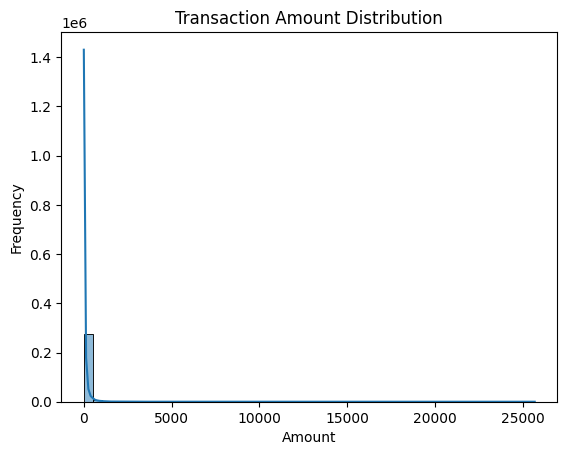

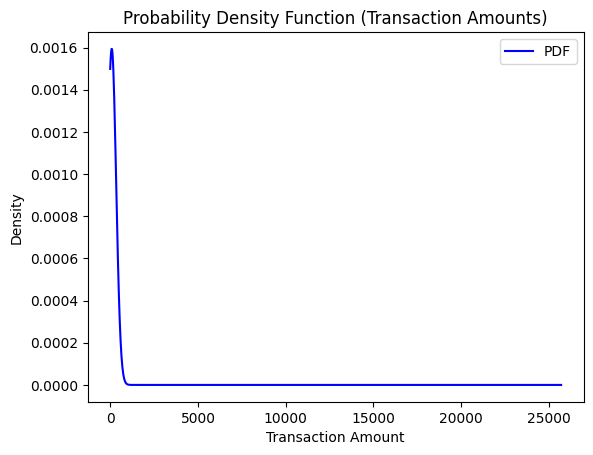

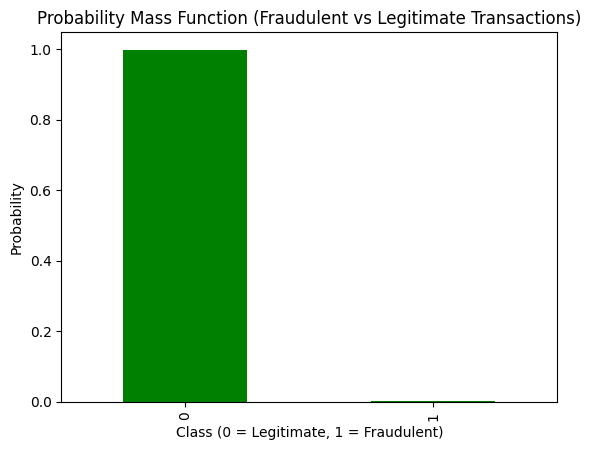

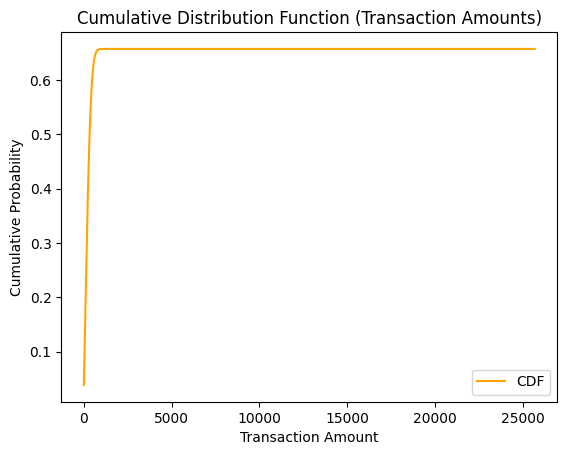

Mean of Amount and Time:
[88.34961925093134, 94813.85957508067]
Median of Amount and Time:
[22.0, 84692.0]
Mode of Amount and Time:
[0    1.0
Name: Amount, dtype: float64, 0    163152.0
Name: Time, dtype: float64]


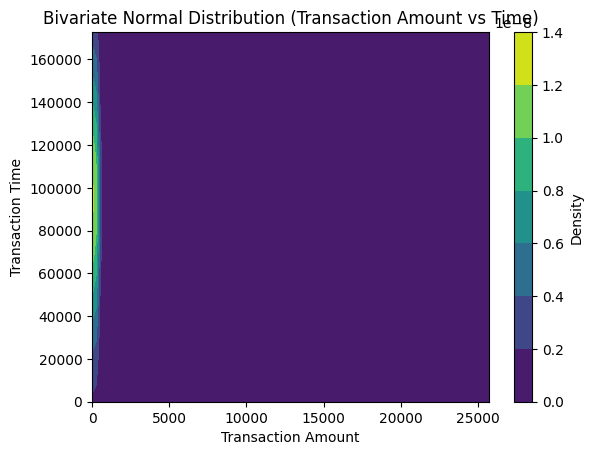

T-Test Statistic: 2.9288, P-Value: 3.5605e-03
Reject the null hypothesis: The means are significantly different.
ANOVA Statistic: 219.1803, P-Value: 7.0900e-142
Reject the null hypothesis: At least one group mean is significantly different.
Class Distribution After SMOTE:
Class
0    284315
1    284315
Name: count, dtype: int64
Linear Regression R-squared: 0.0045
Linear Regression Mean Squared Error: 0.2489
Polynomial Regression R-squared: 0.0060
Polynomial Regression Mean Squared Error: 0.2485


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm, ttest_ind, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # Import SimpleImputer for handling NaNs
from imblearn.over_sampling import SMOTE

# Load dataset
data = pd.read_csv(os.path.join(base_path, "creditcard.csv"))

# Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(data.info())
print("Descriptive Statistics:")
print(data.describe())

# Visualize Transaction Amount Distribution
sns.histplot(data['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Probability Functions and Distributions
# PDF for Transaction Amounts
mu, sigma = data['Amount'].mean(), data['Amount'].std()
x = np.linspace(data['Amount'].min(), data['Amount'].max(), 1000)
pdf = norm.pdf(x, mu, sigma)

plt.plot(x, pdf, label='PDF', color='blue')
plt.title("Probability Density Function (Transaction Amounts)")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()

# PMF for Fraudulent Transactions
fraud_counts = data['Class'].value_counts()
total_transactions = len(data)
pmf = fraud_counts / total_transactions
pmf.plot(kind='bar', color='green')
plt.title("Probability Mass Function (Fraudulent vs Legitimate Transactions)")
plt.xlabel("Class (0 = Legitimate, 1 = Fraudulent)")
plt.ylabel("Probability")
plt.show()

# CDF for Transaction Amounts
cdf = np.cumsum(pdf) * (x[1] - x[0])

plt.plot(x, cdf, label='CDF', color='orange')
plt.title("Cumulative Distribution Function (Transaction Amounts)")
plt.xlabel("Transaction Amount")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.show()

# Bivariate Normal Distribution for Amount and Time
mean = [data['Amount'].mean(), data['Time'].mean()]
median = [data['Amount'].median(), data['Time'].median()]
mode = [data['Amount'].mode(), data['Time'].mode()]

print("Mean of Amount and Time:")
print(mean)
print("Median of Amount and Time:")
print(median)
print("Mode of Amount and Time:")
print(mode)

# Drop rows with NaN or infinite values in 'Amount' and 'Time' columns
data_cleaned = data[['Amount', 'Time']].dropna()  # Drop rows with NaN
data_cleaned = data_cleaned[np.isfinite(data_cleaned).all(1)]  # Drop rows with infinite values

# Calculate covariance using cleaned data
cov = np.cov(data_cleaned['Amount'], data_cleaned['Time'])

x = np.linspace(data['Amount'].min(), data['Amount'].max(), 100)
y = np.linspace(data['Time'].min(), data['Time'].max(), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

rv = multivariate_normal(mean, cov)
Z = rv.pdf(pos)

plt.contourf(X, Y, Z, cmap='viridis')
plt.title("Bivariate Normal Distribution (Transaction Amount vs Time)")
plt.xlabel("Transaction Amount")
plt.ylabel("Transaction Time")
plt.colorbar(label='Density')
plt.show()

# Significance Testing
# T-Test for Fraudulent vs Legitimate Transaction Amounts
fraud_amounts = data[data['Class'] == 1]['Amount']
legit_amounts = data[data['Class'] == 0]['Amount']

stat, p_value = ttest_ind(fraud_amounts, legit_amounts, equal_var=False)
print(f"T-Test Statistic: {stat:.4f}, P-Value: {p_value:.4e}")
if p_value < 0.05:
    print("Reject the null hypothesis: The means are significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in means.")

# ANOVA Test for Time Periods
bins = [0, 21600, 43200, 64800, 86400]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
data['Time_Period'] = pd.cut(data['Time'], bins=bins, labels=labels)
groups = [data[data['Time_Period'] == period]['Amount'] for period in labels]

anova_stat, anova_p_value = f_oneway(*groups)
print(f"ANOVA Statistic: {anova_stat:.4f}, P-Value: {anova_p_value:.4e}")
if anova_p_value < 0.05:
    print("Reject the null hypothesis: At least one group mean is significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference between group means.")

# Handle Class Imbalance
smote = SMOTE(random_state=42)

# Drop rows with NaN in 'Class' column before applying SMOTE
data_no_nan = data.dropna(subset=['Class'])

# Apply SMOTE to the data without NaNs
X_resampled, y_resampled = smote.fit_resample(data_no_nan[['Amount']], data_no_nan['Class'])

print("Class Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Regression Analysis
# Define features and target
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression R-squared: {r2_linear:.4f}")
print(f"Linear Regression Mean Squared Error: {mse_linear:.4f}")

# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
y_pred_poly = poly_model.predict(X_poly_test)

# Evaluate Polynomial Regression
r2_poly = r2_score(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
print(f"Polynomial Regression R-squared: {r2_poly:.4f}")
print(f"Polynomial Regression Mean Squared Error: {mse_poly:.4f}")

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Train model with class weights to handle imbalance
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)


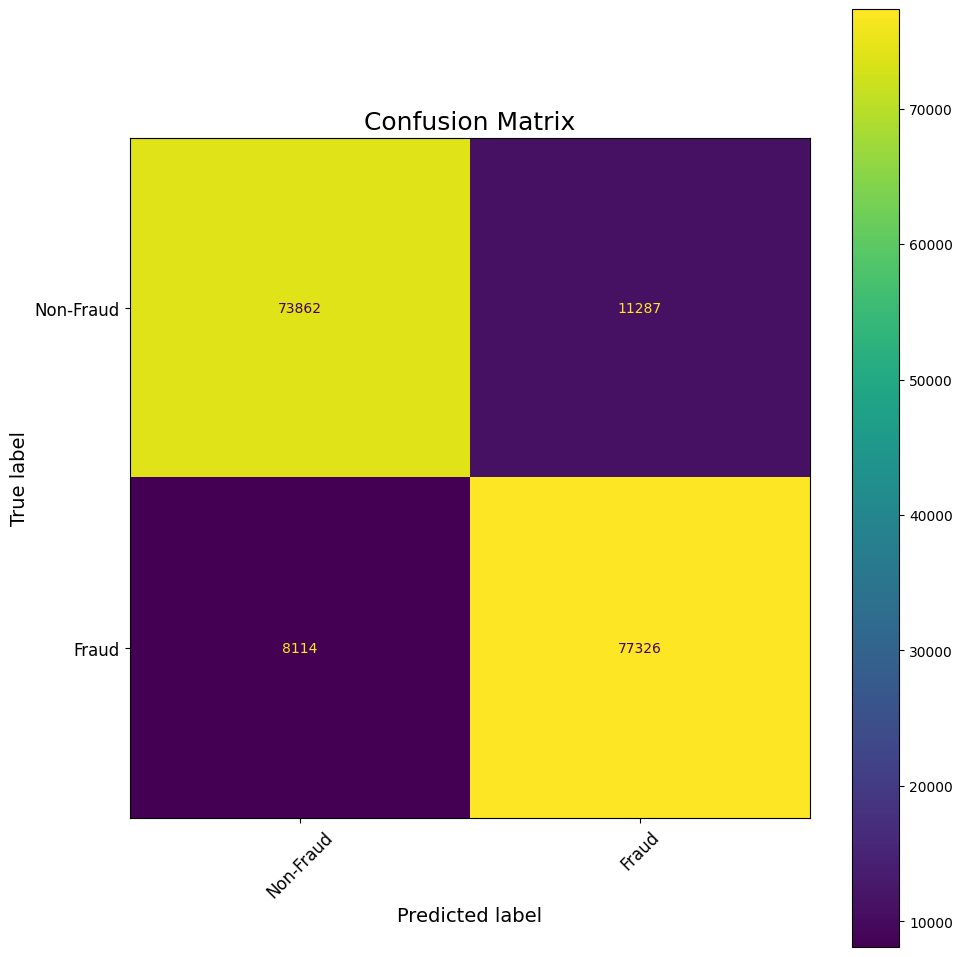

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
disp.plot(ax=ax, cmap='viridis', colorbar=True)

ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel("Predicted label", fontsize=14)
ax.set_ylabel("True label", fontsize=14)
ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


This notebook builds a machine learning model to detect fraudulent credit card transactions in an imbalanced dataset. The workflow includes data preprocessing, stratified train-test split, and model training with class_weight="balanced" to handle class imbalance. Model performance is evaluated using precision, recall, F1-score, ROC/PR curves, and a clear confusion matrix for interpretability.